<a href="https://colab.research.google.com/github/IsakLarsson/Deep-Learning-labs/blob/main/Reinforcement_learning_Isak_%C3%85man_Larsson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Isak Åman Larsson

# Laboration on Reinforcement Learning (RL) for Pole Cart Gym

By Tomas Nordström
with code from Kalle Prorok

This uses the CartPole environment from OpenAI's gym: https://gym.openai.com/ or more specificly: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py (Note that this is a Bang-Bang controller with no neutral operation, that is, it either moves left of it moves right in each time step). The original code from a paper by Sutton can be found at http://incompleteideas.net/sutton/book/code/pole.c



**Instruktioner**

Du ska nu experimentera med Q-learning för ett miniproblem ”Cart-pole” och försöka få den inverterade pendeln på en vagn att stå upp så länge som möjligt.

Plotta hur mycket belöning systemet får för varje episod för att se hur systemet beter sig över tid? Vilka 4 mätvärden ingår i tillståndsinformationen som är grund för om man ska putta vagnen till höger eller vänster? Gör gärna fler experiment med samma parameteruppsättning för att också få en känsla för hur stabila resultaten är. En sammanlagd reward, dvs hur många steg som systemet lyckas få pinnen att fortsätta stå upp, på mer än 180 räknas som mycket bra.

Testa med några olika parametervärden, t ex öka antalet episoder för att få en känsla för när resultaten börjar stabilisera sig; öka/minska inlärningstakten; eller t.o.m. öka kvantifieringen av tillståndsrymden (men inte för mycket då det ju gör Q-tabellen rejält mycket större för varje steg). Även Epsilon, som styr hur girig (exploit) den ska vara att ta ett slumpmässigt beslut för sin ”action” kan vara intressant att experimentera med.

För att bättre förstå, de troligen mediokra resultaten, ska du även undersöka Q-tabellen efter träningen. Hur mycket av “världen” har systemet utforskat? Vad säger detta om Q-learning som metod och kan du komma på något som skulle förbättra systemets prestanda och stabilitet.

Med en anpassning av epsilon och inlärningshastighet över tid (börja högt för att möjliggöra mer utforskning och inlärning till en början och sedan senare minska värdet för att stabilisera) kan förbättra prestandan avsevärt. Se Geron Kapitel 18 "exploration policies". Implementera detta (är kanske 4-5 rader kod!) för att se om det hjälper, men se till att jämföra med fallet då dessa parametrar är oföränderliga.

**Historik**
* 2020-05-06 Initial version 
* 2020-05-07 Uppdaterade instruktionerna (ersatte fjolårets som glömts kvar)
* 2020-12-07 Ersatte argmax med en biblioteksfunktion


# Set up the Colab environment

Extra dependencies för att få displayen att fungera


In [640]:
# Select Tensorflow 2.0
%tensorflow_version 2.x

In [641]:
!apt-get install -y xvfb x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.8).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [642]:
pip install -U pyvirtualdisplay

Requirement already up-to-date: pyvirtualdisplay in /usr/local/lib/python3.6/dist-packages (1.3.2)


In [643]:
import pyvirtualdisplay
_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

In [644]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import tensorflow.keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical
print('Keras version:',tensorflow.keras.__version__)

# Helper libraries
import os
import numpy as np
import pandas as pd
import cv2
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from numpy import argmax

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt

# For this Lab
import random
import gym

#animation
import matplotlib.animation as animation
matplotlib.rc('animation', html='jshtml')

TensorFlow version: 2.4.0
Keras version: 2.4.0


In [645]:
# Test for GPU and determine what GPU we have
# Could also use https://github.com/anderskm/gputil
import sys
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    IN_COLAB = 'google.colab' in sys.modules
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
    !nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b8f5b9a9-3469-1ea0-4f55-bdbffbd940c9)


# The Main RL Code ##

In [646]:
# Define some useful functions
def running_mean(x, N=10):
    """ Return the running mean of N element in a list
    """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)


In [647]:
# Inspired by RL researchers and written by Kalle Prorok for a Deep Learning Course
# Umeå Sweden 2019

# A set of parameters that is working well
EPISODES       = 20000  # Number of eposides to run, org. val was only 1000, but that is too little
EPSILON        = 0.5    # Chance to explore (take a radom step instead of an "optimal" one), org val = 0.1
GAMMA          = 0.9    # How much previous steps should be rewarded now, discount rate, org val = 0.9
LEARNING_RATE  = 0.1   # Learning rate, org val = 0.1
DISCRETE_STEPS = 12     # Discretization steps per state variable (aviod odd numbers), org val = 10 

# The state space is the four dimensions: x, x_dot, theta, theta_dot
def make_state(observation):
    """ Map a 4-dimensional state to a state index
    """
    low = [-4.8, -10., -0.41888, -10.] # ( changed -0.41 into more correct -0.41888 for 24 deg.)
    high = [4.8, 10., 0.41888, 10.]
    state = 0

    for i in range(4):
        # State variable, projected to the [0, 1] range
        state_variable = (observation[i] - low[i]) / (high[i] - low[i])

        # Discretize. A variable having a value of 0.53 will lead to the integer 5,
        # for instance.
        state_discrete = int(state_variable * DISCRETE_STEPS)
        state_discrete = max(0, state_discrete) # should not be needed
        state_discrete = min(DISCRETE_STEPS-1, state_discrete)

        state *= DISCRETE_STEPS
        state += state_discrete
        # Make state into a 4 "digit" number (between 0 and 9999, if 10 discrete steps)
    return state


In [648]:
# (Compare to https://www.geeksforgeeks.org/q-learning-in-python/ )
average_cumulative_reward = 0.0

episode_reward = np.zeros(EPISODES)
# Create the Gym environment (CartPole)
env = gym.make('CartPole-v1')

print('Action space is:', env.action_space)
print('Observation space is:', env.observation_space)

# Q-table for the discretized states, and two actions
num_states = DISCRETE_STEPS ** 4
qtable = [[0., 0.] for state in range(num_states)]
print('Q-table = %.0f x %.0f' % (len(qtable),len(qtable[0]) ))

# Loop over episodes
# Code to make the training animated
# https://stackoverflow.com/questions/52726475/display-openai-gym-in-jupyter-notebook-only
for i in range(EPISODES):
    state4D = env.reset()
    state = make_state(state4D)

    terminate = False
    cumulative_reward = 0.0

    # Loop over time-steps
    frames = []
    while not terminate:
        # Compute what the greedy action for the current state is
        #print(state)
        qvalues = qtable[state]
        greedy_action = argmax(qvalues) #0 el 1

        # Sometimes, the agent takes a random action, to explore the environment
        if random.random() < EPSILON:
            action = random.randrange(2)
        else:
            action = greedy_action

        # Perform the action
        next_state, reward, terminate, info = env.step(action)  # info is ignored
        next_state = make_state(next_state)
        
        # Show the simulated environment. A bit difficult to make it work.            
        # env.render()
        #frames.append(env.render(mode="rgb_array"))

        # Update the Q-Table
        td_error = reward + GAMMA * max(qtable[next_state]) - qtable[state][action]
        qtable[state][action] += LEARNING_RATE * td_error
        # Update statistics
        cumulative_reward += reward
        state = next_state
    # store reward for every episode
    episode_reward[i] = cumulative_reward
    
    # Adapt epsilon and learning rate here

    if ((i % 500) == 0):
      EPSILON = EPSILON / 1.08
      LEARNING_RATE = LEARNING_RATE/1.02
      print(EPSILON, LEARNING_RATE)

    # Per-episode statistics
    if ((i % 500)==0):
      print(i, cumulative_reward, sep=',')
    env.close()

Action space is: Discrete(2)
Observation space is: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Q-table = 20736 x 2
0.4629629629629629 0.09803921568627451
0,12.0
0.42866941015089155 0.09611687812379853
500,28.0
0.39691612051008474 0.09423223345470444
1000,93.0
0.3675149263982266 0.09238454260265141
1500,13.0
0.34029159851687646 0.09057308098299158
2000,123.0
0.31508481344155226 0.08879713821861919
2500,49.0
0.2917451976310669 0.08705601786139136
3000,12.0
0.2701344422509878 0.08534903711901114
3500,19.0
0.2501244835657294 0.08367552658726582
4000,146.0
0.23159674404234204 0.0820348299875155
4500,220.0
0.2144414296688352 0.08042630390932892
5000,199.0
0.19855687932299554 0.07884931755816561
5500,19.0
0.18384896233610698 0.0773032525080055
6000,162.0
0.17023052068158054 0.07578750245882893
6500,218.0
0.15762085248294494 0.07430147299885188
7000,252.0
0.14594523378050456 0.07284458137142341
7500,189.0
0.13513447572268938 0.07141625624649355
8000,279.0
0.125124514558

In [649]:
#def update_scene(num, frames, patch):
#    patch.set_data(frames[num])
#    return patch,

#def plot_animation(frames, repeat=False, interval=40):
#   fig = plt.figure()
#    patch = plt.imshow(frames[0])
#    plt.axis('off')
#    anim = animation.FuncAnimation(
#        fig, update_scene, fargs=(frames, patch),
#        frames=len(frames), repeat=repeat, interval=interval)
#    plt.close()
#    return anim

In [650]:
#plot_animation(frames)

# Analysis...
Try a number of parameter settings and try to get stable and good performance. Do not dispare if the results seems poor, it is very tricky to get good results!  

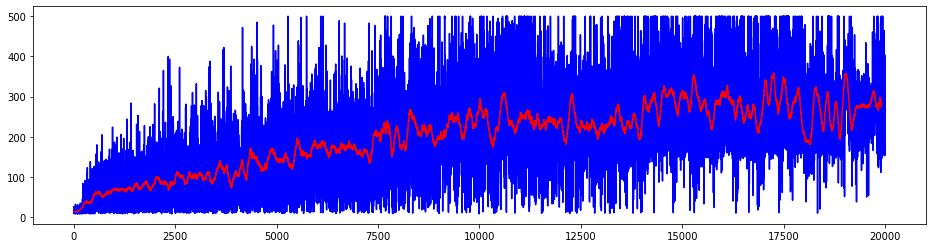

In [651]:
# Plot the results from a training run
plt.figure(figsize=(16, 4))
plt.plot(episode_reward,"b")
y_av = running_mean(episode_reward, N=100)
plt.plot(y_av,"r")

Lyckats få den att förbättra sig något över tid men det är väldigt svårt att få ett bra resultat där den inte går uppåt i början men sedan verkar glömma bort och tappa prestanda igen. Den är lite all over the place men den ökar ändå stadigt. Börjar på ett ganska högt epsilon för att uppmuntra till utforskning och sänker det med 8% var 500e iteration, en väldigt enkel variant på minskande epsilon. Samma sak med learning raten som sänks med endast 2 procent då den börjar mycket lägre. Minimum värdena dippar fortfarande ner på låga värden även om de har lyfts en hel del del. Medelvärdet ligger och hovrar mellan 200-300 vilket jag skulle säga är väldigt bra och jag är nöjd med det resultatet.

Efter att ha testat en hel drös med olika parameterkomibnationer har jag kommit fram till att det som gett bäst resultat har varit att öka antalet discrete steps till 12 från 10. Det har genast ökat prestandan och hållt den höjd mellan körningar. Tycker att denna lab har varit väldigt svår att få till bra och kanske inte heller så värst givande då det till största del bara gäller att testa olika kombinationer och hoppas på det bästa.

# Continued Analysis
To better understand why the performance is so poor, you should check how much of the Q-table is filled in (corresponding to how much of the environment that is explored). What part of the Q-table is filled in? What conclusions can we make out of this? 

With an adaptation of epsilon and learning rate (starting high to allow for more exploration and learning in the beginning, and then later reduce the value) can significantly improve the performance. See Geron's "exploration policies".

Vi kan kolla hur stor andel av tabellen som är noll och därmed outforskad

In [652]:
qarray = np.array(qtable)
np.mean(qarray == 0)

0.9794801311728395

Här ser vi att ca 98% av tabellen består av nollor och är därmed outforskad. Det får mig att tänka att det är en hel del slösat utrymme och att Q-learning är en ganska innefektiv metod då den tar rätt länge att träna och får en stor beslutsrymd. Detta exempel har också bara 4 dimensioner av sitt state, en mer avancerad applikation hade nog fått ett enormt stor beslutsrymd. Då detta är ett ganska "trivialt" problem så tror jag att jag kommer att experimentera med OpenAI Gyms andra environments för skojs skull och se om jag inte hittar något mer spännande.